# 2.03c - Analysis of Night Clusters and BG Excursions
This notebook is used to analyse the night clusters and look for indications of BG control during the night by identifying BG excursions. The aim is to see if there are any patterns in the data that may indicate disturbances in sleep patterns, and to see if there are any differences between the night clusters.

Traditionally, glycaemic control has been assessed primarily through HbA1c measurements, which provide an average blood glucose level over the preceding two to three months. HbA1c remains a standard measure for predicting and preventing diabetes complications in a clinical setting, but has limitations. It does not capture daily fluctuations in glucose levels, including dangerous highs and lows. Therefore, patients can record a normal HbA1c but still experience significant glycaemic variability, which can lead to complications that will only present symptoms once they are having an impact on the body. CGM data provides a more detailed view of glucose levels, allowing for the assessment of glycaemic variability and excursions outside of target ranges. It can help to identify patterns in glucose levels that may not be captured by HbA1c alone, more effectively highlighting possible disturbances in sleep patterns.

Time in range (TIR) is a good indicator of BG control, but the definition of the ideal range is highly individual. For adults in the UK the general guidance is a target range is between 3.9–10 mmol/l. There are a number of factors that can influence this range however, such as disease duration, comorbities, pregnancy and others \cite{ElSayed2023}. For instance, for individuals in gestation are guided by a 3.5–7.8 mmol/l range, yet we do not have data on most of these influences to personalise the target accordingly. A search of academic papers on guidance for fasting target ranges refers mainly to diagnosis levels rather than guidance for those with T1D though some important institutes do indicate a  and therefore assume a consistent 3.9-10 mmol/l (70-180 mg/dL) concentration range as a general guideline, but this would normally be adjusted for individual needs.

If the level of blood glucose dips below the target range during sleep for a 15 minute period or longer, this is considered a nocturnal hypoclcaemic event. This is a significant event that can lead to complications such as seizures, coma, and even death. The same applies for hyperglycaemic events, where the blood glucose level rises above the target range for a 15 minute period or longer. These events are considered nocturnal hyperglycaemic events and can lead to complications such as diabetic ketoacidosis (DKA) and long-term complications such as cardiovascular disease. <REF> A characteristic of nocturnal hypoglycaemic events is that they are often asymptomatic unlike in healthy people, meaning that the patient may not be aware of the event \cite{Schultes2007}. The inference therefore is that these events may not be a cause of sleep disturbance of themselves. However, if intervention is required during an excursion (particularly where the closed loop system is unable to regulate the blood glucose levels), they are required to take quick-acting carbohydrates and persist in testing and iterating to ensure it comes back into range. This can lead to overnight disturbances.


In [117]:
from diptest import diptest
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import display
from scipy.stats import linregress, ttest_1samp
from datetime import time, datetime, timedelta

from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.dba import dba_by_cluster
from src.config import PROCESSED_DATA_DIR
from src.helper import rank_minutes_series, normalise_overnight_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all[['night_start_date', 'bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max', 'tsne_cluster_label']].rename(columns={'tsne_cluster_label': 'cluster'})
print(f'Night count check: {len(df_all.reset_index()[["id","night_start_date"]].drop_duplicates())}')

2025-07-25 13:20:48.781 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   0%|          | 0/6454 [00:00<?, ?it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:   9%|▉         | 593/6454 [00:00<00:04, 1284.00it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 722/6454 [00:00<00:04, 1242.84it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning:

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'iob max__count_above__t_100', 'cob mean__minimum', 'cob max__minimum'}
PCA reduced dimensions from 75 to 2.
Night count check: 922


In [119]:
df_all = df_all.join(df[['bg std', 'bg count', 'cob count', 'iob count']], how='left')  # Bring in columns for subsequent analysis, counts required for calc of background mean, std for background std and cv
df_all.to_csv(PROCESSED_DATA_DIR / 'night_clusters.csv', index=True)
df_all.to_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet', index=True)
bg_min = 70
bg_max = 180

def add_excursion_vars(df, var_name, bg_min, bg_max):
    min_name = 'min' if var_name == 'minmax' else 'mean'
    max_name = 'max' if var_name == 'minmax' else 'mean'
    df[f'bg_min_excursion_by_{min_name}'] = df[f'bg {min_name}'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
    df[f'bg_max_excursion_by_{max_name}'] = df[f'bg {max_name}'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)

    def excursion_type(row):
        if pd.notna(row[f'bg_min_excursion_by_{min_name}']) and pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IBR and IAR'
        elif pd.notna(row[f'bg_min_excursion_by_{min_name}']):
            return 'IBR'
        elif pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IAR'
        else:
            return np.nan

    df['bg_excursion_type'] = (df[[f'bg_min_excursion_by_{min_name}', f'bg_max_excursion_by_{max_name}']].
                               apply(lambda x: excursion_type(x), axis=1))

    return df

df_all = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)

BG excursion values are calculated as the difference between the BG min and max values and the target range of 70-180 mg/dL (3.9-10 mmol/l). In both cases, the value is calculated as an absolute value so that magnitude can be compared later on.

In [120]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

We'll first look to see if there is any prevalence of BG excursions in the night clusters. Sleep is considered key to maintaining optimal cardiovascular and metabolic health. The relationship between sleep and glyaecemic control is complex and bi-directional. The effects of disrupted sleep on glucose control \cite{Farabi2016} and - conversely - impact of diabetes treatment on sleep \cite{Brod2013} have been studied but require more research. For instance, studies have associated the rapid decline in blood glucose over short periods with awakenings from sleep \cite{Pillar2003}, but little is known about causation.

By studying the amount of excursions outside a target glucose range, we can get an idea as to the frequency and extent of these excursions. Based on the assumptions given by other research, such excursions may infer - by association - some form of disturbance of sleep. Setting accurate thresholds is not possible when generalising over individuals.

The period we will consider studying once more is the 22:00-06:00 period as defining an arbitrary 'nocturnal' period. This is a period where we would expect the patient to be asleep and therefore not consuming food or taking insulin. Given our intervals are at 30 minutes we cannot accurately measure TOR, but we can look at intervals outside the target range, as well as the level of excursion above or below the target. At each interval we can focus on the BG min and max values at each interval which will have captured the peaks and troughs without smoothing these values, especially if short-lived. We know the OpenAPS system effectively manages BG in patients, so we would expect to see a lower number of excursions in the night clusters compared to the day clusters.

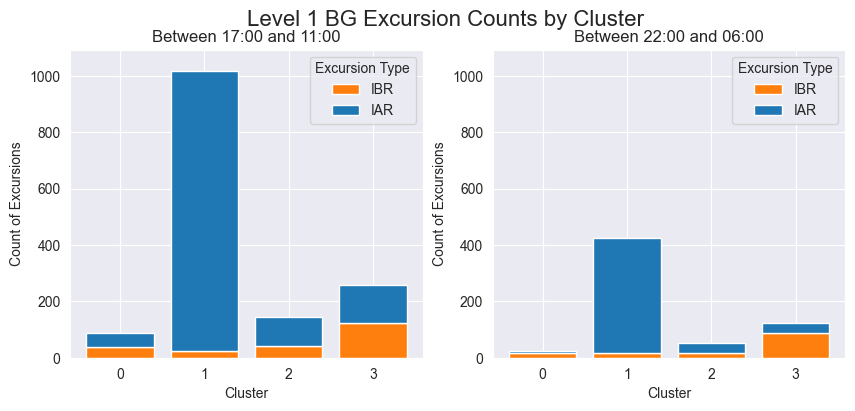

bg_excursion_type,IAR,IBR
cluster,,
0,49,39
1,993,24
2,103,41
3,135,124


In [145]:
var_cols = {'IAR': '#1f77b4', 'IBR': '#ff7f0e'}

def plot_bar_plots(df, ax, title, ymax):
    df_pivot = df.pivot(index='cluster', columns='bg_excursion_type', values='bg_excursions').fillna(0)
    bottom = None
    for col in df_pivot.columns.sort_values(ascending=False):
        ax.bar(df_pivot.index, df_pivot[col], bottom=bottom, label=col, color=var_cols[col])
        if bottom is None:
            bottom = df_pivot[col]
        else:
            bottom += df_pivot[col]
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count of Excursions')
    ax.set_ylim(0, ymax * 1.1)
    ax.legend(title='Excursion Type')

fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('Level 1 BG Excursion Counts by Cluster', fontsize=16)
df_all_excursion_summary = df_all.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
df_overnight_excursion_summary = df_overnight.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
ymax = df_all_excursion_summary['bg_excursions'].max()
plot_bar_plots(df_all_excursion_summary, axes[0], 'Between 17:00 and 11:00', ymax)
plot_bar_plots(df_overnight_excursion_summary, axes[1], 'Between 22:00 and 06:00', ymax)

plt.show()

df_all_excursion_summary.pivot(index='cluster', columns='bg_excursion_type', values='bg_excursions')

In [146]:
def violin_plot_data(df):
    df_excursions = df[['cluster', 'bg_min_excursion_by_min', 'bg_max_excursion_by_max']].reset_index().copy()
    df_excursions['time'] = df_excursions['datetime'].dt.time
    df_excursions['time_rank'] = rank_minutes_series(df_excursions['time'], time(17, 0))
    return (df_excursions.
                 rename(columns={'bg_min_excursion_by_min': 'IBR', 'bg_max_excursion_by_max': 'IAR'}).
                 melt(id_vars=['cluster', 'time', 'time_rank'],
                      value_vars=['IBR', 'IAR'],
                      var_name='excursion_type',
                      value_name='count').
                 dropna(subset=['count']).
                 sort_values(by=['cluster', 'excursion_type', 'time_rank']))

df_l1_violin = violin_plot_data(df_all)

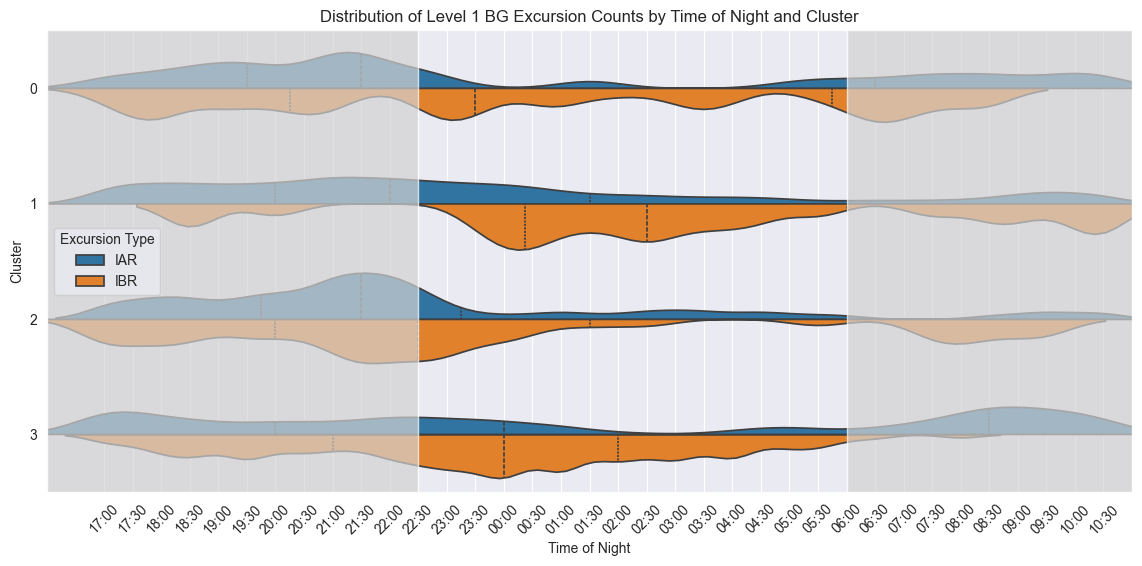

In [147]:
def get_xticks(df):
    df_new = df.copy()
    df_new['time'] = df_new['time'].apply(lambda x: x.strftime('%H:%M'))
    return df_new[['time_rank','time']].set_index('time_rank').drop_duplicates().sort_index()['time']

xticks = get_xticks(df_l1_violin)

def plot_violin(df, xticks):
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.violinplot(data=df, x='time_rank', y='cluster', hue='excursion_type', split=True, inner='quartile', bw_method=0.1, orient='h')
    shade_periods = [
        (-1, 12), # 17:00 to 22:00
        (27, 37)   # 06:00 to 11:00 (next day)
    ]
    for start_dt_obj, end_dt_obj in shade_periods:
        ax.axvspan(start_dt_obj, end_dt_obj, facecolor='lightgray', alpha=0.7, zorder=3)
    plt.title('Distribution of Level 1 BG Excursion Counts by Time of Night and Cluster')
    plt.xlabel('Time of Night')
    plt.ylabel('Cluster')
    plt.xlim(-1, 37)
    plt.legend(title='Excursion Type')
    plt.xticks(ticks=sorted(df['time_rank'].unique()), labels=xticks, rotation=45)
    plt.show()

plot_violin(df_l1_violin, xticks)

In [148]:
norm_time = datetime(1900, 1, 1, 0, 0)
df_l1_violin['norm_time'] = df_l1_violin['time'].apply(lambda x: normalise_overnight_time(x, 11))
df_l1_violin['minutes_delta'] = df_l1_violin['norm_time'].apply(lambda x: ((x - norm_time).total_seconds() / 60)+15)
df_l1_violin['count_times_minutes'] = df_l1_violin['count'] * df_l1_violin['minutes_delta']

for t, group in df_l1_violin.groupby('excursion_type'):
    print(f'Excursion Type mean times: {t}')
    # CALCULATE THE Q1 an Q3 of the IRQ to determine the 50% range
    c = group.groupby('cluster').agg({'count': 'sum', 'count_times_minutes': 'sum'})
    a = c['count_times_minutes'] / c['count']
    b = a.apply(lambda x: (norm_time+timedelta(minutes=x)).time())
    for cluster, t in b.items():
        print(f'Cluster {cluster}: {t}')
    print('\n')

Excursion Type mean times: IAR
Cluster 0: 23:48:34.049172
Cluster 1: 23:10:25.034949
Cluster 2: 21:48:18.078603
Cluster 3: 01:53:55.669906


Excursion Type mean times: IBR
Cluster 0: 01:26:52.340426
Cluster 1: 03:55:06.521739
Cluster 2: 23:16:46.273063
Cluster 3: 23:59:20.952381




In [149]:
def weighted_quantile(values, quantiles, sample_weight=None):
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]
    weighted_cdf = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_cdf /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_cdf, values)

def weighted_q1_q3(group):
    q1 = weighted_quantile(group['minutes_delta'], [0.25], sample_weight=group['count'])[0]
    q3 = weighted_quantile(group['minutes_delta'], [0.75], sample_weight=group['count'])[0]
    norm_time = datetime(1900, 1, 1, 0, 0)
    return pd.Series({
        'q1': (norm_time + timedelta(minutes=q1)).time(),
        'q3': (norm_time + timedelta(minutes=q3)).time()
    })

iqr_times = df_l1_violin.groupby(['cluster', 'excursion_type'])[['minutes_delta','count']].apply(weighted_q1_q3)
print('Interquartile Range (IQR) of minutes delta for each cluster and excursion type:')
print(iqr_times)

Interquartile Range (IQR) of minutes delta for each cluster and excursion type:
                                     q1               q3
cluster excursion_type                                  
0       IAR                    19:45:00  05:46:17.027027
        IBR             20:45:56.250000         06:45:00
1       IAR                    19:15:00         01:15:00
        IBR                    00:50:00  08:03:56.842105
2       IAR                    18:45:00         22:45:00
        IBR                    19:45:00  00:33:24.545455
3       IAR             20:25:35.714286         08:45:00
        IBR                    21:45:00         02:15:00


In [150]:
def is_nocturnal(t):
    midnight = time(0, 0)
    return (t >= night_start and t <= midnight) or (t <= morning_end and t >= midnight)

def calculate_excursion_proportions(df_violin):
        
    df_violin['is_nocturnal'] = df_violin['time'].apply(is_nocturnal)
    
    proportions = df_violin.groupby(['cluster', 'is_nocturnal'])['excursion_type'].agg(
        ibr=lambda x: (x == 'IBR').sum(),
        iar=lambda x: (x == 'IAR').sum(),
    ).reset_index().melt(
        id_vars=['cluster', 'is_nocturnal'],
        value_vars=['ibr', 'iar'],
        var_name='excursion_type',
        value_name='count')
    pivot_df = proportions.pivot(index=['cluster', 'excursion_type'], columns='is_nocturnal', values='count')
    percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    display(percent_df)
    n_largest = percent_df[True].nlargest(2).index
    print(f'Average of other nocturnal excursion counts in level 1: {percent_df[True].loc[percent_df[True].index.difference(n_largest)].mean(): .2f}%')

    for x in n_largest:
        data = percent_df[True].loc[percent_df[True].index.difference([x])].to_list()
        test_value = percent_df[True].loc[x]
        t_stat, p_value = ttest_1samp(data, test_value)
        print(f't-statistic for {x} value {test_value}: {t_stat:.3f}, p-value: {p_value:.3g}')

calculate_excursion_proportions(df_l1_violin)

is_nocturnal                False      True 
cluster excursion_type                      
0       iar             89.795918  10.204082
        ibr             74.358974  25.641026
1       iar             76.837865  23.162135
        ibr             41.666667  58.333333
2       iar             82.524272  17.475728
        ibr             85.365854  14.634146
3       iar             85.925926  14.074074
        ibr             50.000000  50.000000

Average of other nocturnal excursion counts in level 1:  17.53%
t-statistic for (1, 'ibr') value 58.333333333333336: -7.148, p-value: 0.000378
t-statistic for (3, 'ibr') value 50.0: -4.318, p-value: 0.00499


This analysis of the density of the level 1 BG excursions shows the distributions of excursions for the nocturnal period in the context of the broader 17:00-11:00 period. (The violin plot uses a low kernel bandwidth to avoid smoothing and tails that extend greatly beyond the observed timerange, hence the observable sensitivity of the distribution to fluctuation). It is noticeable that for clusters 1 and 3, that there is visibly higher density within the nocturnal periods for IBR. They have mean times for their distributions as 02:45 and 00:28 respectively with 50% of excursions falling between 00:15-05:45 and 21:45-03:15 respectively (as per weighted mean and Q1/Q3 IQR calculation). The nocturnal periods for cluster 1 and 3 have 58% ad 45% of the IBR excursions respectively in comparison to the non-nocturnal period, compared to an 34% (cluster 1) and 29% (cluster 2), both having statistical significance from the mean across all excursion types for all clusters (with p-value < 0.05 in a one sample t-test). They are unique proportions across all clusters for both IBR and IAR excursion types which average at just 25% of excursions in the nocturnal period.

In [151]:
df_overnight_excursion_summary.head()

,cluster,bg_excursion_type,bg_excursions
0,0,IAR,9
1,0,IBR,15
2,1,IAR,410
3,1,IBR,15
4,2,IAR,38


In [152]:
def mean_excursions_by_night(df):
    excursions_per_night = (
        df.groupby(['id', 'night_start_date'])['bg_excursion_type']
        .apply(lambda x: x.notna().sum())
        .reset_index(name='excursion_count')
    )
    return excursions_per_night['excursion_count'].mean()

print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')

Mean excursions per night for 17:00-11:00 period (including zeros): 1.64
Mean excursions per night for 22:00-06:00 period (including zeros): 0.68


The plots show some interesting findings. Firstly, there are a significant number of excursions, more than had been expected. Secondly, there is a predominance of IAR excursions. Third, cluster 1 sees a significant number of IAR excursions (over 60% more), and cluster 3 sees more IBR excursions than other nights, though very few IAR excursions by comparison. However, these numbers are based on minimum and maximum values when resampled, giving no indication in the time out of range. Studies often use a time period of 15 minutes or upward to define an excursion, but this is not possible with the 30 minute intervals we have. By using the mean (aggregated from all readings in the 30 minute interval) we can get a better idea of the excursions, but this will not be entirely accurate as it may smooth out some of the excursions. Averaging these give us a slightly different picture, one would expect.

In [153]:
df_all_by_mean = add_excursion_vars(df_all, 'mean', bg_min, bg_max)
df_overnight_by_mean = add_excursion_vars(df_overnight, 'mean', bg_min, bg_max)
print('Mean excursions per night calculated using bg mean values:')
print(f'Mean excursions per night for 17:00-11:00 period (including zeros): {mean_excursions_by_night(df_all_by_mean): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros): {mean_excursions_by_night(df_overnight_by_mean): .2f}')

Mean excursions per night calculated using bg mean values:
Mean excursions per night for 17:00-11:00 period (including zeros):  1.31
Mean excursions per night for 22:00-06:00 period (including zeros):  0.56


In [154]:
# Per-night aggregation: stats and mutually exclusive flags
nightly = (
    df_overnight.groupby(['id', 'night_start_date', 'cluster'])
    .agg(
        max_excursion=('bg_max_excursion_by_max', 'max'),
        min_excursion=('bg_min_excursion_by_min', 'min'),
        IBR_night=('bg_excursion_type', lambda x: (x == 'IBR').any()),
        IAR_night=('bg_excursion_type', lambda x: (x == 'IAR').any()),
        excursion_count=('bg_excursion_type', lambda x: x.notna().sum()),
        IBR_count=('bg_excursion_type', lambda x: (x == 'IBR').sum()),
        IAR_count=('bg_excursion_type', lambda x: (x == 'IAR').sum())
    )
    .reset_index()
)
# Mutually exclusive flags
nightly['IBR_and_IAR_night'] = nightly['IBR_night'] & nightly['IAR_night']
nightly['IBR_only_night'] = nightly['IBR_night'] & ~nightly['IAR_night']
nightly['IAR_only_night'] = nightly['IAR_night'] & ~nightly['IBR_night']

# Per-patient aggregation
summary_by_id = (
    nightly.groupby('id')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)
summary_by_cluster = (
    nightly.groupby('cluster')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)

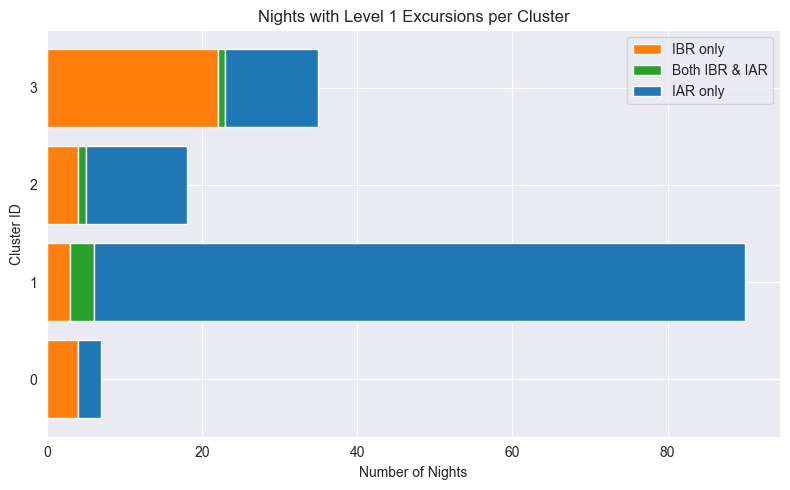

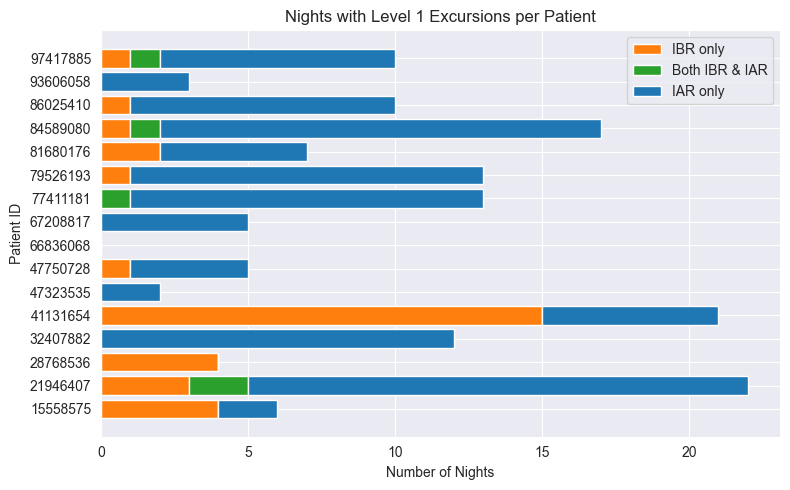

In [155]:
plot_df = summary_by_cluster[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary_by_cluster.index

def plot_nights_with_excursions(plot_df, title):
    fig, ax = plt.subplots(figsize=(8, 5))
    ids = plot_df.index.astype(str)
    bottom = None

    ax.barh(ids, plot_df['nights_with_IBR'], label='IBR only', color='#ff7f0e')
    ax.barh(ids, plot_df['nights_with_both_IBR_IAR'],
            left=plot_df['nights_with_IBR'],
            label='Both IBR & IAR', color='#2ca02c')
    ax.barh(ids, plot_df['nights_with_IAR'], left=plot_df['nights_with_IBR'] + plot_df['nights_with_both_IBR_IAR'], label='IAR only', color='#1f77b4')

    ax.set_xlabel('Number of Nights')
    ax.set_ylabel(f'{title} ID')
    ax.set_title(f'Nights with Level 1 Excursions per {title}')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_nights_with_excursions(plot_df, 'Cluster')

plot_df = summary_by_id[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary_by_id.index  # Ensure patient IDs are the index
plot_nights_with_excursions(plot_df, 'Patient')

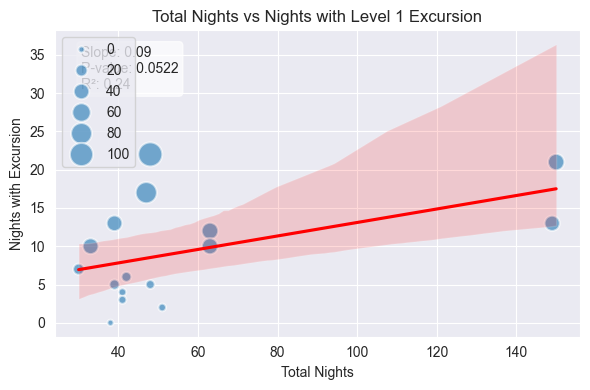

In [156]:
x = summary_by_id['total_nights']
y = summary_by_id['nights_with_excursion']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary_by_id, x='total_nights', y='nights_with_excursion',
    size='excursion_count', sizes=(20, 300), edgecolor='white', linewidth=1.5, alpha=0.6, ax=ax,
)

sns.regplot(
    summary_by_id, x='total_nights', y='nights_with_excursion',
    scatter=False, ax=ax, color='red', line_kws={'label': 'Fit Line'}
)
ax.legend(title='Excursion Count')

ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nP-value: {p_value:.3g}\nR²: {r_squared:.2f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.title('Total Nights vs Nights with Level 1 Excursion')
plt.xlabel('Total Nights')
plt.ylabel('Nights with Excursion')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [157]:
res = linregress(summary_by_id['total_nights'], summary_by_id['excursion_count'])
print('Linear Regression results for Total Nights vs Excursion Count:')
print(f'Slope: {res.slope:.2f}, P-value: {res.pvalue:.3g}, R²: {res.rvalue**2:.2f}')

Linear Regression results for Total Nights vs Excursion Count:
Slope: 0.17, P-value: 0.45, R²: 0.04


The first and most notable observation is the high number of excursions that exist, following a linear relationship between the number of nights and the number of excursions. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the a linear regression between the nights with excursions and total nights high correlation (with p-value < 0.05 and $R^2$ of 0.85 showing a good fit), indicating that the number of excursions does increase consistently with the number of nights. However, the number of nights is not necessarily correlated with the number of excursions which follows a Pearsons Correlation of $R=0.36$. This highlights that the instance of excursions follows an alternative relationship, likely with a predominance by individual, rather than the sample size.

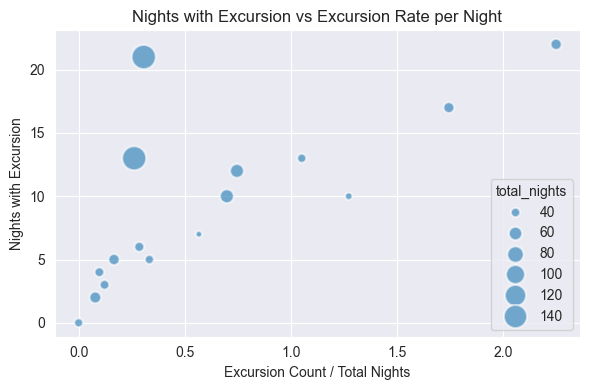

In [158]:
summary_by_id['excursion_ratio'] = summary_by_id['excursion_count'] / summary_by_id['total_nights']

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary_by_id, x='excursion_ratio', y='nights_with_excursion',
    size='total_nights', sizes=(20, 300), edgecolor='white', linewidth=1.5, alpha=0.6, ax=ax
)
plt.xlabel('Excursion Count / Total Nights')
plt.ylabel('Nights with Excursion')
plt.title('Nights with Excursion vs Excursion Rate per Night')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualising the excursion ratio against the number of nights with excursions shows little information of discernible value with the number of patients we have in the sample. While there appears to be a correlation of sorts in the patients with the smaller number of nights with excursions, the picture is very different to those patient we have a night sample size of 120 or more.

In [159]:
def hist_data(df):
    new_df = df[['cluster', 'bg_min_excursion_by_min', 'bg_max_excursion_by_max']].reset_index().copy()
    new_df['time'] = new_df['datetime'].dt.time
    new_df['time_rank'] = rank_minutes_series(new_df['time'], night_start)
    new_df = (new_df.
             rename(columns={'bg_min_excursion_by_min': 'IBR', 'bg_max_excursion_by_max': 'IAR'}).
             melt(id_vars=['cluster', 'time', 'time_rank'],
                  value_vars=['IBR', 'IAR'],
                  var_name='excursion_type',
                  value_name='excursion_value').
             dropna(subset=['excursion_value']).
             sort_values(by='time_rank'))
    return new_df

df_hist_excursion = hist_data(df_overnight)
xticks = get_xticks(df_hist_excursion)

NameError: name 'va_cols' is not defined

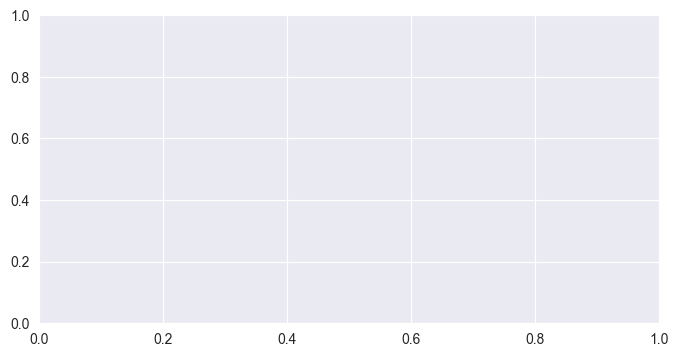

In [160]:
def all_density_plot(df_hist_excursion, xticks):
    fig = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    #palette = sns.color_palette(n_colors=df_hist_excursion['excursion_type'].nunique())
    excursion_types = df_hist_excursion['excursion_type'].unique()

    sns.histplot(
        df_hist_excursion, x='time_rank', hue='excursion_type', weights='excursion_value',
        stat='density', common_norm=False, binwidth=30, discrete=True, ax=ax, palette=va_cols
    )

    plt.xticks(ticks=df_hist_excursion['time_rank'].unique(), labels=xticks, rotation=45)
    plt.xlabel('Time of Night')
    plt.ylabel('Density of Excursion Value')
    plt.title('Density of Level 1 BG Excursion Values by Time of Night')

    # Custom legend handles
    handles = [
        mpatches.Patch(color=palette[i], label=excursion_types[i])
        for i in range(len(excursion_types))
    ]
    plt.legend(handles=handles, title='Excursion Type')

    plt.tight_layout()
    plt.show()

all_density_plot(df_hist_excursion, xticks)

In [137]:
df_overnight[['bg_max_excursion_by_max', 'bg_min_excursion_by_min']].describe()

,bg_max_excursion_by_max,bg_min_excursion_by_min
count,2397.000000,608.000000
mean,44.398415,10.143914
std,41.063787,8.276588
min,1.000000,0.500000
25%,14.000000,4.000000
50%,32.000000,7.000000
75%,64.000000,15.000000
max,221.000000,31.000000


In [138]:
from diptest import diptest
from scipy.stats import skew, kurtosis
ibr_values = df_overnight['bg_min_excursion_by_min'].dropna()
dip, p_value = diptest(ibr_values)
print(f'Dip Test for IBR: Dip Statistic = {dip:.4f}, p-value = {p_value:.4f}')

s = skew(ibr_values)
k = kurtosis(ibr_values)
print(f'Skewness for IBR: {s:.4f}, Kurtosis for IBR: {k:.4f}')
print(f'Bimodality Coefficient for IBR: {(s**2 + 1) / k}')


Dip Test for IBR: Dip Statistic = 0.0450, p-value = 0.0000
Skewness for IBR: 0.9973, Kurtosis for IBR: 0.0867
Bimodality Coefficient for IBR: 23.00548793511563


The density of the excursion value in histogram shows how the magnitude of blood glucose excursions (either IBR or IAR) is distributed across different time intervals during the night, for each cluster. Density means the plot is normalised so the area under the curve (or sum of bar heights) equals 1 for each group, allowing comparison of the shape of the distribution, regardless of the total number or sum of excursions. The excursion value is the amount by which blood glucose is outside the target range (either above or below). It provides a view of the times excursions are more or less likely, and how large they tend to be.

Over all sample nights, the IAR distribution is distinct and consistent over a count of 2397 excursion intervals, with a Q1 of 14 mg/dL and Q3 of 74 mg/dL, therefore 50% of excursions above L1 target range falls between 14 and 32 mg/dL. The maximum excursion however is 221 mg/dL. Intervals with excursions below L1 target range number 608, with a Q1 of 4 mg/dL and a Q3 of 15 mg/dL (and are absolute values given these are below the range). The maximum excursion is 31 mg/dL making these excursions less pronounced (and of course as a negative below the threshold). The IBR distribution also appears multimodal, evidenced with statistical significance from a dip test with p-value of < 0.05 that it is not unimodal, and a bimodality coefficient of 23 indicating a strong bimodial distribution. Looking at this by cluster may provide more insight into the distribution of excursions, and whether there are any differences between the clusters.

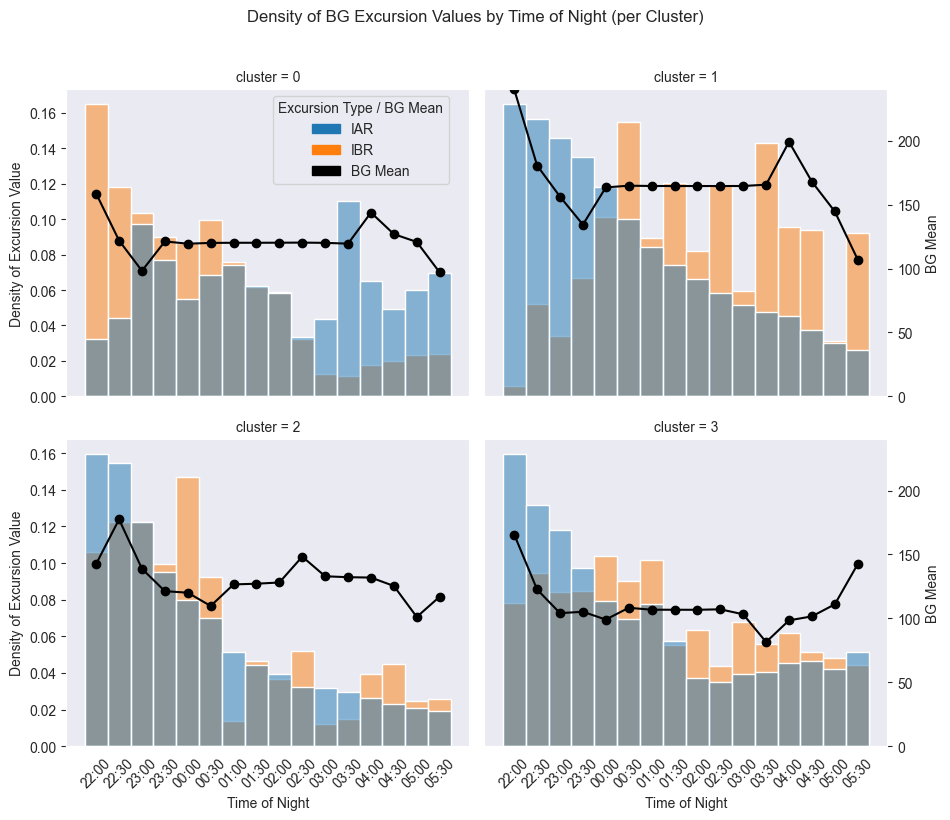

In [139]:
def excursion_density_by_cluster(df_hist_excursion, df_dba, xticks):
    max_dba = df_dba['bg mean'].max()

    g = sns.FacetGrid(
        df_hist_excursion,
        col='cluster',
        col_wrap=2,
        height=4,
        aspect=1.2,
        sharey=False
    )
    g.map_dataframe(
        sns.histplot,
        x='time_rank',
        hue='excursion_type',
        weights='excursion_value',
        stat='density',
        common_norm=False,
        binwidth=30,
        discrete=True,
        legend=False
    )
    axes = g.axes.flatten()
    ncols = 2

    for idx, (ax, cluster) in enumerate(zip(axes, g.col_names)):
        ax.set_xticks(df_hist_excursion['time_rank'].unique())
        ax.set_xticklabels(xticks, rotation=45)
        ax.set_xlabel('Time of Night')
        ax.set_ylabel('Density of Excursion Value')

        # Overlay line plot on secondary y-axis
        ax2 = ax.twinx()
        cluster_dba = df_dba[df_dba['cluster'] == cluster]
        ax2.plot(
            range(1, len(cluster_dba)+1),
            cluster_dba['bg mean'],
            color='black',
            marker='o',
            linestyle='-',
            label='BG Mean'
        )
        ax2.set_ylim(0, max_dba)
        ax2.set_ylabel('BG Mean')
        ax.grid(False)
        ax2.grid(False)

        # Remove secondary y-tick labels and label from left column
        if idx % ncols == 0:
            ax2.set_yticks([])
            ax2.set_ylabel(None)
        # Remove primary y-tick labels and label from right column
        if idx % ncols == 1:
            ax.set_yticks([])
            ax.set_ylabel(None)

    # Legend for histogram
    palette = g._legend_data if hasattr(g, '_legend_data') else None
    if palette:
        handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
    else:
        excursion_types = df_hist_excursion['excursion_type'].unique()
        colors = sns.color_palette(n_colors=len(excursion_types))
        handles = [mpatches.Patch(color=colors[i], label=etype) for i, etype in enumerate(excursion_types)]

    # Add a single line legend
    line_handle = mpatches.Patch(color='black', label='BG Mean')
    g.fig.legend(handles=handles + [line_handle], title='Excursion Type / BG Mean', loc='upper right', bbox_to_anchor=(0.48, 0.92))

    g.fig.suptitle('Density of BG Excursion Values by Time of Night (per Cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

variables = ['cob mean', 'iob mean', 'bg mean']

df_dba_by_cluster = dba_by_cluster(df_overnight, variables, night_start.hour, morning_end.hour, 'cluster')
excursion_density_by_cluster(df_hist_excursion, df_dba_by_cluster, xticks)


As we can see here, the distribution of excursion values for IAR over cluster 1, 2, 3 contribute to the overall distribution that starts with a peak and tails off towards the end of the night. This would naturally be expected as the patient is likely to be asleep and not consuming food or taking insulin. Cluster 0 however is more noisy, and it is IBR that has a more distinct distribution, akin to that of IBR in other clusters. IBR in general is more noisy, but the distribution is more pronounced in cluster 0. This may indicate that the patient is more likely to have IBR during the night, which may be indicative of a disturbance in their sleep pattern.

## Level 2 Hypoglycaemia and Hyperglycaemia Thresholds
There are two other thresholds that exist given their consideration as clinically significant. These are the level 2 hypoglycaemia threshold of 54 mg/dL (3.0 mmol/l) and the level 2 hyperglycaemia threshold of 250 mg/dL (13.9 mmol/l). These thresholds are used to indicate more severe excursions that may require intervention, such as a glucagon injection or insulin bolus. We can look at the number of excursions that occur outside these thresholds, and see if there is any difference between the night clusters.

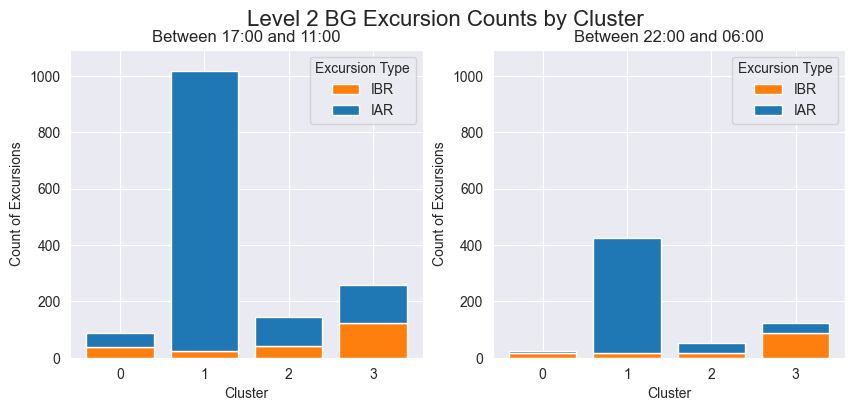

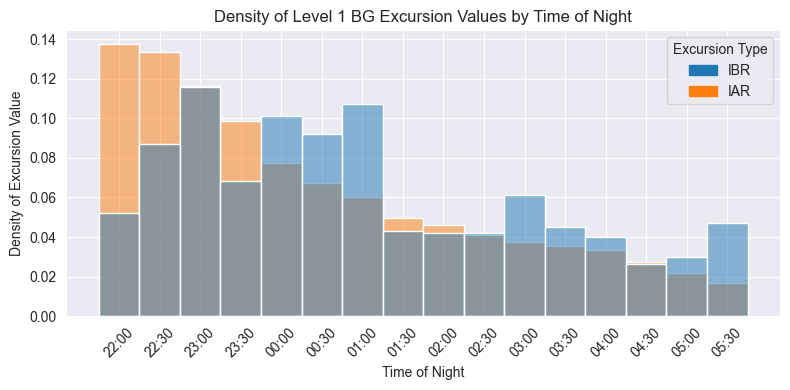

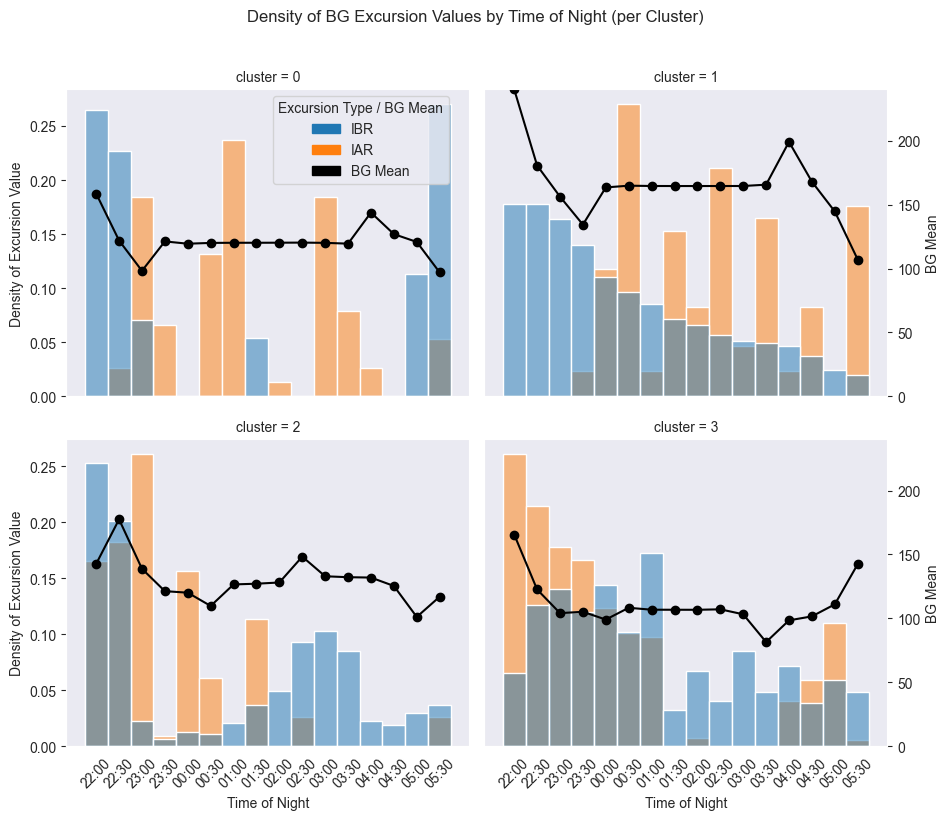

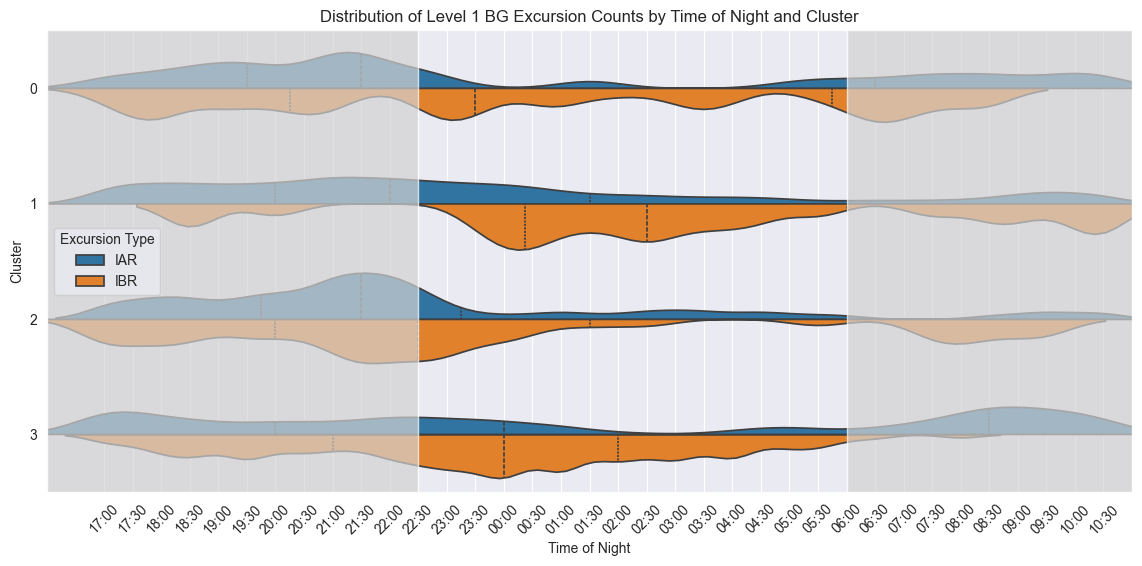

bg_excursion_type  IAR  IBR
cluster                    
0                   49   39
1                  993   24
2                  103   41
3                  135  124
Mean excursions per night for 17:00-11:00 period (including zeros): 1.64
Mean excursions per night for 22:00-06:00 period (including zeros): 0.68
       bg_max_excursion_by_max  bg_min_excursion_by_min
count               494.000000               131.000000
mean                 39.091093                 7.465649
std                  38.300996                 4.924503
min                   1.000000                 1.000000
25%                  12.000000                 3.000000
50%                  27.000000                 6.000000
75%                  51.750000                12.500000
max                 151.000000                15.000000


is_nocturnal                False      True 
cluster excursion_type                      
0       iar             89.795918  10.204082
        ibr             74.358974  25.641026
1       iar             76.837865  23.162135
        ibr             41.666667  58.333333
2       iar             82.524272  17.475728
        ibr             85.365854  14.634146
3       iar             85.925926  14.074074
        ibr             50.000000  50.000000

Average of other nocturnal excursion counts in level 1:  17.53%
t-statistic for (1, 'ibr') value 58.333333333333336: -7.148, p-value: 0.000378
t-statistic for (3, 'ibr') value 50.0: -4.318, p-value: 0.00499


In [142]:
bg_min = 54
bg_max = 250
df_all_level2 = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)
df_overnight_level2 = add_excursion_vars(df_overnight, 'minmax', bg_min, bg_max)
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('Level 2 BG Excursion Counts by Cluster', fontsize=16)
df_all_level2_excursion_summary = df_all_level2.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
df_overnight_level2_excursion_summary = df_overnight_level2.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
ymax = df_all_level2_excursion_summary['bg_excursions'].max()
plot_bar_plots(df_all_level2_excursion_summary, axes[0], 'Between 17:00 and 11:00', ymax)
plot_bar_plots(df_overnight_level2_excursion_summary, axes[1], 'Between 22:00 and 06:00', ymax)
plt.show()


df_hist_excursion_l2 = hist_data(df_overnight_level2)
xticks = get_xticks(df_hist_excursion)
all_density_plot(df_hist_excursion_l2, xticks)
df_dba_by_cluster_l2 = dba_by_cluster(df_overnight_level2, variables, night_start.hour, morning_end.hour, 'cluster')
excursion_density_by_cluster(df_hist_excursion_l2, df_dba_by_cluster_l2, xticks)
df_l2_violin = violin_plot_data(df_all_level2)
xticks = get_xticks(df_l2_violin)
plot_violin(df_l2_violin, xticks)
print(df_all_level2_excursion_summary.pivot(index='cluster', columns='bg_excursion_type', values='bg_excursions'))
print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')
print(df_overnight_level2[['bg_max_excursion_by_max', 'bg_min_excursion_by_min']].describe())
calculate_excursion_proportions(df_l2_violin)

The volume of excursions at level 2 thresholds is obviously much reduced, totaling 494 for IAR and 131 for IBR for the nocturnal periods, an mean of 0.68 a night, compared to L1 excursions at 3.28. What we can see here is much less signal in the data, presumed to be due to the lower count of excursions to provide a pattern. While the number of excursions is naturally much lower, much of the distribution is lost and the excursions tend to appear more random, apart from some cases such as IBR in cluster 3 which has a well-defined distribution. This is a good indicator that the level 2 thresholds are more likely to present unique events and disturbances. Clusters 1 and 3 have strong proportions of IBR excursions in the nocturnal period at L2 as seen with L1, though now at 58% and 50% respectively, against a backdrop of generally reduced proportions during the nocturnal period, averaging just 17.5% of nocturnal excursions against the broader 17:00-11:00 window. The observable density of excursion amplitudes shows some notable patterns. While most cluster/excursion type combinations provide little signal, given the fewer excursion events, these are seen in the